In [4]:
import pandas as pd
import numpy as np
import seaborn as sns         
import matplotlib.pyplot as plt
from  sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix 
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
import pickle
from nltk.stem.snowball import SnowballStemmer   #used for stemmes words
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,classification_report, ConfusionMatrixDisplay, confusion_matrix


##### Reading Datasets 

In [7]:
df=pd.read_csv("new_data_urls.csv")

In [8]:
print(df.shape)
df.head()

(822010, 2)


,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0



### EDA ###


In [9]:
df['status'].value_counts()  ##0-phishing(bad) , ##1-legitimate(good)

status
1    427028
0    394982
Name: count, dtype: int64

In [10]:
df.isnull().sum()##check null values in dataset

url       0
status    0
dtype: int64

In [11]:
df.duplicated().sum() ##before 

np.int64(13968)

In [12]:
df.drop_duplicates(inplace=True)##Drop Duplicate values 

In [13]:
df.duplicated().sum() ##after

np.int64(0)

In [14]:
df['status'].value_counts()

status
1    427028
0    381014
Name: count, dtype: int64

######## Count plot to visualize the distribution of 0 (legitimate) and 1 (phishing) ##############

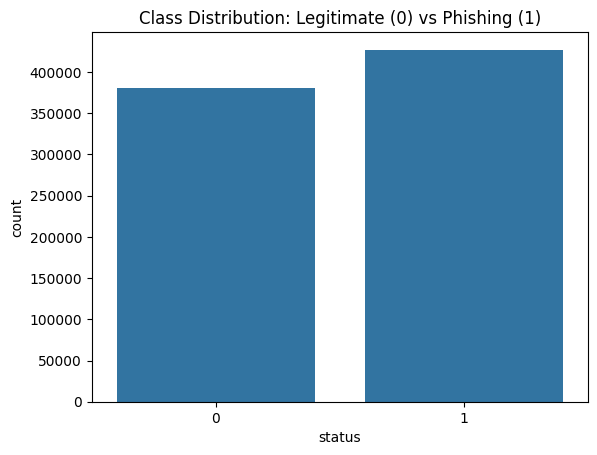

status
1    52.847253
0    47.152747
Name: proportion, dtype: float64

In [15]:
sns.countplot(x='status', data=df)
plt.title('Class Distribution: Legitimate (0) vs Phishing (1)')
plt.show()

# Percentage of each class
df['status'].value_counts(normalize=True) * 100

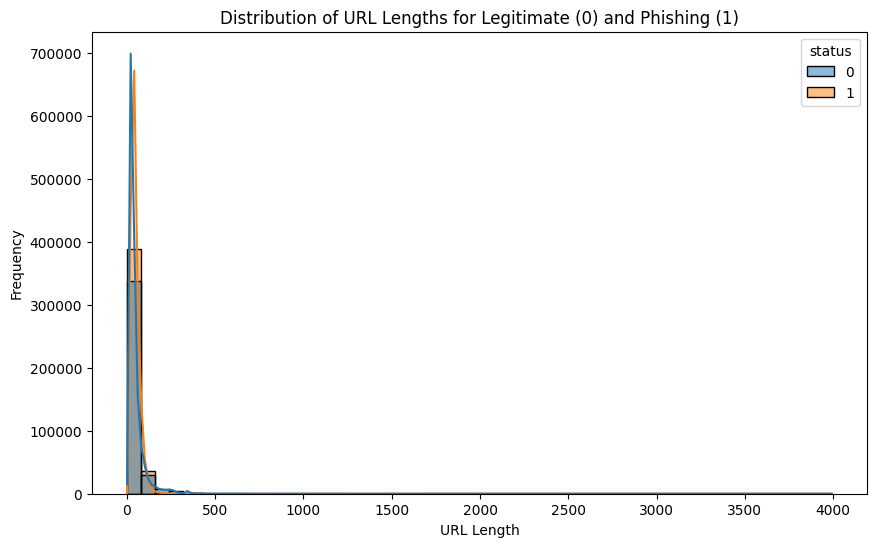

In [16]:
# Create a new column for URL length
df['url_length'] = df['url'].apply(lambda x: len(x))

# Plotting URL length distribution for phishing vs legitimate
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='url_length', hue='status', kde=True, bins=50)
plt.title('Distribution of URL Lengths for Legitimate (0) and Phishing (1)')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()
##This diagram shows the distribution of URL lengths.
# URL length alone is not a reliable feature for distinguishing between phishing and legitimate websites due to their similar distributions


##### Feature Engineering


###### Make Custom Tokenizer Class For URL column #######

In [17]:

def makeTokens(f):
    tkns_BySlash = str(f.encode('utf-8')).split('/')	# make tokens after splitting by slash
    total_Tokens = []
    for i in tkns_BySlash:
        tokens = str(i).split('-')	# make tokens after splitting by dash
        tkns_ByDot = []
        for j in range(0,len(tokens)):
            temp_Tokens = str(tokens[j]).split('.')	# make tokens after splitting by dot
            tkns_ByDot = tkns_ByDot + temp_Tokens
        total_Tokens = total_Tokens + tokens + tkns_ByDot
    total_Tokens = list(set(total_Tokens))	#remove redundant tokens
    if 'com' in total_Tokens:
        total_Tokens.remove('com')	#removing .com since it occurs a lot of times and it should not be included in our features
    return total_Tokens

In [18]:
y = df["status"]
url_list = df["url"]

In [19]:
# Using Custom Tokenizer
vectorizer = TfidfVectorizer(tokenizer=makeTokens)

In [20]:
X = vectorizer.fit_transform(url_list)
# Split into training and testing dataset 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

c:\Users\singh\OneDrive\Desktop\phishing Attack\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



#### Model Buliding


In [21]:
# Create a logistic regression model with class weights
lr= LogisticRegression(class_weight='balanced', solver='liblinear')

lr.fit(X_train, y_train)# Train the model
y_pred = lr.predict(X_test) # Predict on the test set

#### Evaluate the model ###

In [22]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    114281
           1       0.96      0.98      0.97    128132

    accuracy                           0.96    242413
   macro avg       0.96      0.96      0.96    242413
weighted avg       0.96      0.96      0.96    242413



ROC AUC Score: 0.9624222818122116


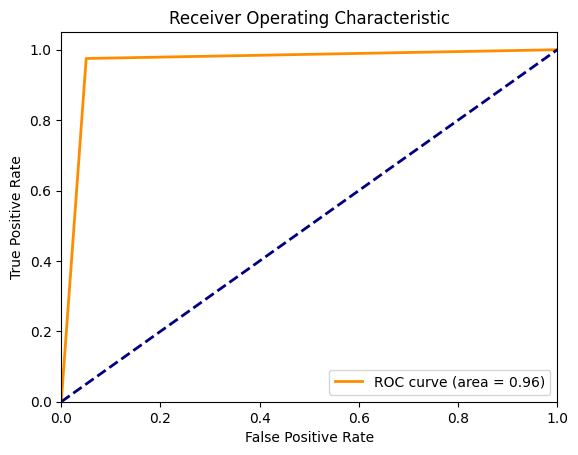

In [23]:
# Print ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test,y_pred))

# Plotting the ROC AUC Curve 
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
lr.score(X_test,y_test) ##check the  accuracy score

0.963145540874458

#### Make Pipeline for automate a sequence of data processing steps ####

In [25]:
pipeline_lr = make_pipeline(TfidfVectorizer(tokenizer=makeTokens), LogisticRegression(class_weight='balanced', solver='liblinear'))

In [26]:
X_train,X_test,y_train, y_test = train_test_split(df.url, df.status,test_size=0.3,random_state=42)

In [27]:
pipeline_lr.fit(X_train,y_train)

c:\Users\singh\OneDrive\Desktop\phishing Attack\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(tokenizer=<function makeTokens at 0x000001883ACFFE20>)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

In [28]:
pipeline_lr.score(X_test,y_test)##accuracy of the Model

0.9644037242227108

###### Convert it into pickle Which is used to serialize and save models or objects,enabling easy storage and reuse without retraining #####

In [29]:
pickle.dump(pipeline_lr,open('phishing_Detection_URL.pkl','wb'))

In [30]:
loaded_model = pickle.load(open('phishing_detection_URL.pkl', 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)

0.9644037242227108


#### --Testing The Model-- 

In [31]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing_detection_URL.pkl', 'rb'))
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("-"*30)
print(result2)  ##0-phishing(bad) , ##1-legitimate(good)

[0 0 0 0]
------------------------------
[1 1 1 1]


In [32]:
X_predict = ["google.com/search=jcharistech",
"google.com/search=faizanahmad",
"pakistanifacebookforever.com/getpassword.php/", 
"www.radsport-voggel.de/wp-admin/includes/log.exe", 
"ahrenhei.without-transfer.ru/nethost.exe ",
"www.itidea.it/centroesteticosothys/img/_notes/gum.exe"]
loaded_model = pickle.load(open('phishing_detection_URL.pkl', 'rb'))
result = loaded_model.predict(X_predict)
print(result)

[1 1 1 0 0 0]


In [33]:
X_predict1=['https://www.youtube.com/watch?v=5L8-g6melVY',
            "https://www.youtube.com/watch?v=5L8-g6melVY",
            "https://github.com/Jcharis/Machine-Learning-In-Julia-JCharisTech/blob/master/Detecting%20Malicious%20Url%20With%20Machine%20Learning%20In%20Python.ipynb",
            "https://cinemacove.netlify.app/"]
loaded_model = pickle.load(open('phishing_detection_URL.pkl', 'rb'))
result = loaded_model.predict(X_predict1)
print(result)

[1 1 1 0]


#### Conclusion 

A logistic regression model was developed to detect phishing websites, achieving an accuracy of 96% on a dataset of 822,010 samples. The model was trained using URL-based features to differentiate between legitimate and phishing websites. Despite high accuracy, URL length alone was found to be insufficient for reliable detection, indicating the need for additional features to improve robustness in real-world applications.